In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [114]:
def get_data(random_state=0):
    np.random.seed(random_state)
    x = np.random.normal(size=50)
    y = 10 * np.sin(x) + np.random.normal(scale=2, size= len(x))
    return x, y

x, y = get_data()

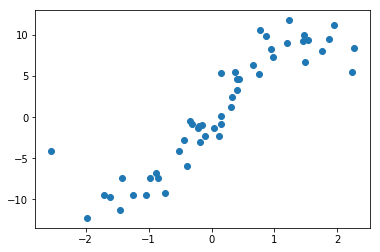

In [115]:
plt.scatter(x, y)

## 最小二乗法による線形回帰

In [116]:
from sklearn.linear_model import LinearRegression

ols = LinearRegression()
ols.fit(x[:,None], y)
weight, bias = ols.coef_[0], ols.intercept_

print('weight:', weight)
print('bias:', bias)

weight: 5.61322907354
bias: 0.0579023045624


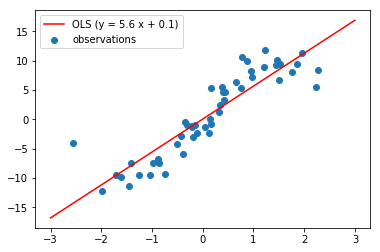

In [117]:
x_preds = np.linspace(-3, 3)
y_preds = x_preds *  weight + bias

plt.scatter(x, y, label='observations')
plt.plot(x_preds, y_preds, c='red', label=f'OLS (y = {weight:.1f} x + {bias:.1f})')
plt.legend()

## 線形結合レイヤーからなるNNによる回帰

In [118]:
import torch
from torch import nn

In [119]:
class RegressionModel(nn.Module):
    def __init__(self, p):
        super(RegressionModel, self).__init__()
        self.linear = nn.Linear(p, 1)
        
    def forward(self, x):
        return self.linear(x)

regression_model = RegressionModel(1)

In [120]:
regression_model

RegressionModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [122]:
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(regression_model.parameters(), lr=0.05)

x, y = get_data()
x_data = torch.from_numpy(x).view(-1,1).float()
y_data = torch.from_numpy(y).float()

n_iterations = 1000
for i in range(n_iterations):
    y_pred = regression_model(x_data).squeeze(-1)
    loss = loss_fn(y_pred, y_data)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (i + 1) % 200 == 0:
        print("[iter %04d] loss: %.4f" % (i+1, loss.item()))

[iter 0200] loss: 452.2278
[iter 0400] loss: 452.2278
[iter 0600] loss: 452.2278
[iter 0800] loss: 452.2278
[iter 1000] loss: 452.2278


In [123]:
print("learned parameters:")
for name, param in regression_model.named_parameters():
    print('   ', name, param.data.numpy())

learned parameters:
    linear.weight [[ 5.61322975]]
    linear.bias [ 0.05790337]


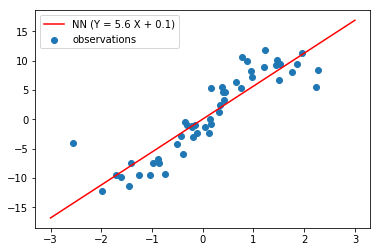

In [124]:
weight = regression_model.linear.weight[0].item()
bias = regression_model.linear.bias.item() 

x_preds = np.linspace(-3, 3)
y_preds = x_preds * weight + bias

plt.scatter(x, y, label='observations')
plt.plot(x_preds, y_preds, c='red', label=f'NN (Y = {weight:.1f} X + {bias:.1f})')
plt.legend()

モデルが一緒で最適化の方法が異なるだけなので、よく似ている。

* 陽に書き下された式で解析解を求めるのが最小二乗法
* NN は目的関数を最小化する確率的勾配法を用いる

## ベイジアン回帰モデル

In [125]:
from functools import partial
import pyro
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.distributions.util import logsumexp
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive
from pyro.infer.mcmc import MCMC, NUTS
import pyro.optim as optim
import pyro.poutine as poutine

def model(x_data, y_data):
    # w の事前分布： 中心 0 でめっちゃ裾広の正規分布
    w_prior = Normal(torch.tensor([[0.]]), torch.tensor([[1000.]]))
    # b の事前分布： 中心 0 でめっちゃ裾広の正規分布
    b_prior = Normal(torch.tensor([[0.]]), torch.tensor([[1000.]]))
    # nn.Module のどのパラメータに対する事前分布かをマップする
    # パラメータは "<self 内のレイヤ名>.<レイヤのパラメータ名>" で指定
    priors = {'linear.weight': w_prior, 'linear.bias': b_prior}
    # sigma はノイズの分散
    scale = pyro.sample("sigma", Uniform(0., 50.))
    # regression_model を確率モデルに昇格
    lifted_module = pyro.random_module("module", regression_model, priors)
    # そのモジュールをインスタンス化
    lifted_reg_model = lifted_module()
    with pyro.plate("map", len(x_data)):
        prediction_mean = lifted_reg_model(x_data).squeeze(-1)
        pyro.sample("obs",
                    Normal(prediction_mean, scale),
                    obs=y_data)
        return prediction_mean

In [126]:
from pyro.contrib.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model)

In [127]:
optim = Adam({"lr": 0.03})
svi = SVI(model, guide, optim, loss=Trace_ELBO(), num_samples=1000)

In [128]:
pyro.clear_param_store()
for j in range(2000):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 500 == 0:
        print("[iteration %04d] loss: %.4f" % (j, loss / len(data)))

[iteration 0000] loss: 0.4406
[iteration 0500] loss: 0.3293
[iteration 1000] loss: 0.3288
[iteration 1500] loss: 0.3293


In [129]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

auto_loc tensor([-2.6954,  5.6057,  0.0786], requires_grad=True)
auto_scale tensor([0.1115, 0.3957, 0.4947], grad_fn=<AddBackward0>)


In [130]:
get_marginal = lambda traces, sites:EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()

def summary(traces, sites):
    marginal = get_marginal(traces, sites)
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        marginal_site = pd.DataFrame(marginal[:, i]).transpose()
        describe = partial(pd.Series.describe, percentiles=[.05, 0.25, 0.5, 0.75, 0.95])
        site_stats[site_name] = marginal_site.apply(describe, axis=1) \
            [["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

def wrapped_model(x_data, y_data):
    pyro.sample("prediction", Delta(model(x_data, y_data)))

posterior = svi.run(x_data, y_data)

In [131]:
# posterior predictive distribution we can get samples from
trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=1000)

post_pred = trace_pred.run(x_data, None)
post_summary = summary(post_pred, sites=['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "x": x_data[:,0],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "y": y_data,
}).sort_values(by='x')

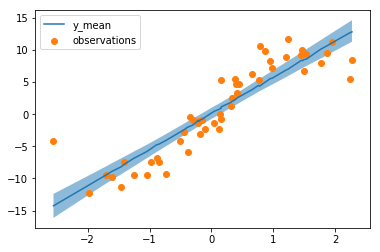

In [132]:
x, y = get_data()

plt.plot(predictions['x'], predictions['y_mean'])
plt.fill_between(predictions['x'], predictions['mu_perc_5'], predictions['mu_perc_95'], alpha=0.5)
plt.scatter(x, y, label='observations')
plt.legend()

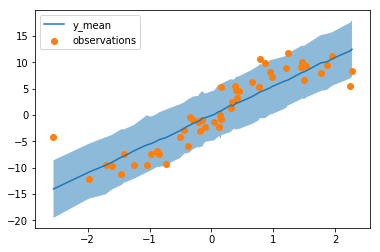

In [110]:
plt.plot(predictions['x'], predictions['y_mean'])
plt.fill_between(predictions['x'], predictions['y_perc_5'], predictions['y_perc_95'], alpha=0.5)
plt.scatter(predictions['x'], predictions['y'], label='observations')
plt.legend()

In [111]:
weights = get_marginal(posterior, ['module$$$linear.weight']).squeeze(1).squeeze(1).flatten()
biases = get_marginal(posterior, ['module$$$linear.bias']).flatten()

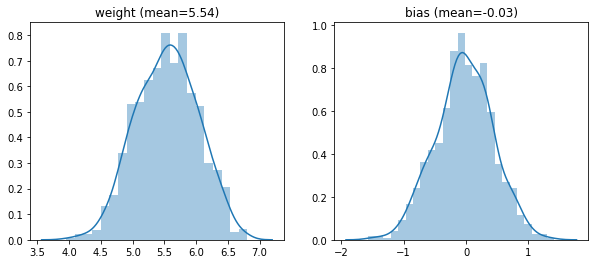

In [112]:
fig, (ax1, ax2) = plt.subplots(figsize=(10,4), ncols=2)

sns.distplot(weights, ax=ax1)
ax1.set_title(f'weight (mean={weights.mean():.2f})')
sns.distplot(biases, ax=ax2)
ax2.set_title(f'bias (mean={biases.mean():.2f})')

plt.show()